## Introduction

Irvine is the largest city in area in Orange County with 65.61 sq miles, and 3rd largest in population with 212,375 people according to census in 2010. 

A number of corporations, particularly in the technology and semiconductor sectors, have their national or international headquarters in Irvine. A lot of them also have office in Bay Area (this analysis will focus on Santa Clara county). During the last couple of years, I had quite a few friends who relocated to Santa Clara county. One big task in the relocation is to find housing, and neighborhood is an important consideration.

Thus, I want to start this analysis on the 13 cities in Santa Clara county and find out which one is the most similar to Irvine.

## Data

Data used in this analysis mainly inclue:
1. Population and demographic related data from wikipedia pages extracted using web scaping approach;
  * https://en.wikipedia.org/wiki/Santa_Clara_County,_California and pages linked
  * https://en.wikipedia.org/wiki/Irvine,_California
2. venue information from foursquare API. 

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

Extract information form wikepedia pages and format in a pandas dataframe.

In [2]:
url='https://en.wikipedia.org/wiki/Santa_Clara_County,_California'
data=requests.get(url).text
soup=BeautifulSoup(data,'html5lib')

In [3]:
tables=soup.find_all('table')

In [4]:
#len(tables)
for index, table in enumerate(tables):
    if 'Population (2010 Census)' in str(table):
        global t
        t =index
table=tables[t]

In [5]:
#tables[t].find_all('th')[1:]
col_name=[]
for row, col in enumerate(table.find_all('th')):
    column=str(col.text)
    column=column[:column.find('[')]
    col_name.append(column)

In [6]:
rows=np.arange(int(len(table.find_all('td'))/4))
#rows
values=table.find_all('td')

In [7]:
sc_city=pd.DataFrame(columns=col_name)
for i in rows:
    start_r=i*4
    r={}
    r['Rank']=str(table.find_all('td')[start_r].text).replace('†','').strip() 
    r['City/Town/etc.']=str(table.find_all('td')[start_r+1].text).replace('†','').strip() 
    r['Municipal type']=str(table.find_all('td')[start_r+2].text).replace('†','').strip() 
    r['Population (2010 Census)']=str(table.find_all('td')[start_r+3].text).replace(',','').replace('†','').strip() 
    sc_city=sc_city.append(r,ignore_index=True)  
sc_city=sc_city[sc_city['Municipal type']=='City'].reset_index(drop=True).drop(['Rank','Municipal type'],axis=1)
sc_city.columns=['name','pop']
sc_city['pop']=sc_city['pop'].astype('int')

city=sc_city.append({'name':'Irvine','pop':212375},ignore_index=True)
city

,name,pop
0,San Jose,945942
1,Sunnyvale,140081
2,Santa Clara,116468
3,Mountain View,74066
4,Milpitas,66790
5,Palo Alto,64403
6,Cupertino,58302
7,Gilroy,48821
8,Campbell,39349
9,Morgan Hill,37882


Get latitude and longitude information from Nominatim to prepare for four square API.

In [8]:
lat=np.zeros(14)
log=np.zeros(14)
for i in range(len(city)):
    geolocator = Nominatim(user_agent="foursquare_agent")
    address = city['name'][i]+', CA'
    
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lat[i]=latitude
    log[i]=longitude
print(lat)
print(log)

[37.3361905 37.3688301 37.2333253 37.3893889 37.4282724 37.4443293
 37.3228934 37.0065078 37.2870626 37.130408  37.2638324 37.3790629
 37.236333  33.6856969]
[-121.890583  -122.036349  -121.6846349 -122.0832101 -121.9066238
 -122.1598465 -122.0322895 -121.5631723 -121.9448818 -121.6544974
 -122.0230146 -122.116578  -121.992458  -117.8259819]


In [9]:
city['lat']=lat
city['log']=log

#city

Get venues in each city.

In [10]:
CLIENT_ID = 'P1ZZBF3SPHZ3YI0PLDCFMUXRAJ3WHKHG1YOYEMCLTLY1JVEL' # your Foursquare ID
CLIENT_SECRET = 'I2WCONUZJPOLSG5V4AKAIWLPIBJMYRJUWHWUCYK03DJHRXHT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 400 # A default Foursquare API limit value
radius=50000

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
venues = getNearbyVenues(names=city['name'],
                                   latitudes=city['lat'],
                                   longitudes=city['log']
                                  )

San Jose
Sunnyvale
Santa Clara
Mountain View
Milpitas
Palo Alto
Cupertino
Gilroy
Campbell
Morgan Hill
Saratoga
Los Altos
Monte Sereno
Irvine


In [34]:
venues[venues['Neighborhood']=='Irvine']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
515,Irvine,33.685697,-117.825982,Bill Barber Community Park,33.687996,-117.822661,Park
516,Irvine,33.685697,-117.825982,Deanna Manning Stadium,33.686801,-117.826397,Baseball Stadium
517,Irvine,33.685697,-117.825982,"San Diego Creek Trail, Peters Canyon Jct",33.689308,-117.825273,Trail
518,Irvine,33.685697,-117.825982,Orange County Dishwasher Repair,33.682077,-117.824389,Home Service


In [13]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 160 uniques categories.


In [14]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,San Jose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,San Jose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,San Jose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,San Jose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,San Jose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Campbell,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.02439,0.000000,0.02439,0.00,0.000000,0.000000,0.00,0.024390
1,Cupertino,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.046512,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.023256,0.023256,0.00,0.000000
2,Gilroy,0.000000,0.000000,0.400000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000
3,Irvine,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.25000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000
4,Los Altos,0.014493,0.000000,0.043478,0.000000,0.00,0.00,0.000000,0.014493,0.000000,...,0.014493,0.014493,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.014493
5,Milpitas,0.000000,0.000000,0.000000,0.023256,0.00,0.00,0.023256,0.000000,0.023256,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.069767,0.000000,0.00,0.000000
6,Monte Sereno,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000
7,Morgan Hill,0.000000,0.000000,0.023256,0.000000,0.00,0.00,0.023256,0.000000,0.000000,...,0.023256,0.000000,0.00000,0.023256,0.00000,0.00,0.046512,0.000000,0.00,0.000000
8,Mountain View,0.000000,0.000000,0.033898,0.000000,0.00,0.00,0.000000,0.000000,0.033898,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.016949,0.00,0.033898
9,Palo Alto,0.000000,0.014493,0.014493,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.014493,0.028986,0.00,0.014493


In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Campbell,Italian Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Coffee Shop,Burger Joint,Restaurant,Recording Studio,Café,Pub
1,Cupertino,Mobile Phone Shop,Coffee Shop,Chinese Restaurant,Bank,Shipping Store,Bakery,Hotel,Asian Restaurant,Furniture / Home Store,Gym / Fitness Center
2,Gilroy,American Restaurant,Shipping Store,Music Venue,Rock Club,Yoga Studio,Dive Bar,Farmers Market,Falafel Restaurant,Electronics Store,Dumpling Restaurant
3,Irvine,Home Service,Trail,Baseball Stadium,Park,Hawaiian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store
4,Los Altos,Coffee Shop,Pizza Place,Italian Restaurant,Mexican Restaurant,American Restaurant,Bakery,Bank,Breakfast Spot,Sushi Restaurant,Ice Cream Shop


Calculate distance for different number of clusters and find out the number of clusters optimal for the analysis.

In [19]:
# set number of clusters
ssd  = []
for k in range(1,10):
    grouped_clustering = grouped.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
    ssd.append(kmeans.inertia_)
# check cluster labels generated for each row in the dataframe
Sum_of_squared_distances=pd.DataFrame(ssd,columns=['error'])
Sum_of_squared_distances.reset_index(inplace=True)
Sum_of_squared_distances['index']=Sum_of_squared_distances['index']+1
Sum_of_squared_distances.columns=['k','error']
Sum_of_squared_distances

,k,error
0,1,1.556605
1,2,0.665887
2,3,0.411390
3,4,0.179937
4,5,0.143786
5,6,0.112209
6,7,0.087995
7,8,0.066830
8,9,0.044680


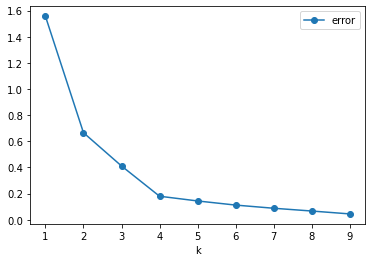

In [20]:
Sum_of_squared_distances.plot(x='k',y='error',kind='line', marker='o')

The curve is flattened after 4 clusters, and thus I picked 4 as number of clusters.

In [21]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(grouped_clustering)

In [22]:
kmeans.labels_

array([1, 1, 3, 0, 1, 1, 2, 1, 1, 1, 1, 1], dtype=int32)

It looks like among all citeis in Santa Clara, most are similar except 3 cities, which forms their own cluster.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = city

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
merged = merged.merge(neighborhoods_venues_sorted, left_on='name', right_on='Neighborhood')

merged.head() # check the last columns!

,name,pop,lat,log,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Jose,945942,37.336191,-121.890583,1,San Jose,Mexican Restaurant,Sandwich Place,Cocktail Bar,Pub,Bar,Bank,Coffee Shop,Ice Cream Shop,Lounge,Steakhouse
1,Sunnyvale,140081,37.368830,-122.036349,1,Sunnyvale,Coffee Shop,Chinese Restaurant,Grocery Store,Mexican Restaurant,Burger Joint,Bank,American Restaurant,North Indian Restaurant,Dumpling Restaurant,Massage Studio
2,Mountain View,74066,37.389389,-122.083210,1,Mountain View,Coffee Shop,Park,Bakery,Indian Restaurant,American Restaurant,Sushi Restaurant,Bookstore,Hotel,Bank,Grocery Store
3,Milpitas,66790,37.428272,-121.906624,1,Milpitas,Indian Restaurant,Vietnamese Restaurant,Sandwich Place,Chinese Restaurant,Mexican Restaurant,Korean Restaurant,Café,Fast Food Restaurant,Ramen Restaurant,Bubble Tea Shop
4,Palo Alto,64403,37.444329,-122.159847,1,Palo Alto,Ice Cream Shop,Café,Coffee Shop,Hotel,Diner,Juice Bar,Chinese Restaurant,Indian Restaurant,Mobile Phone Shop,Spa


In [24]:
label=merged[merged['name']=='Irvine'].reset_index(drop=True).at[0,'Cluster Labels']
similar_cities=merged[merged['Cluster Labels']==label]
similar_cities

,name,pop,lat,log,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Irvine,212375,33.685697,-117.825982,0,Irvine,Home Service,Trail,Baseball Stadium,Park,Hawaiian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store


Unfortunately, Irvine is one of the 3 cities with its own cluster.

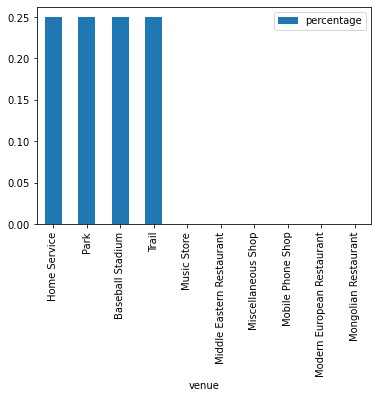

In [29]:
city_list=merged[merged['Cluster Labels']==0][['name','Cluster Labels']]
city_list_subgroup=city_list.merge(onehot,left_on='name',right_on='Neighborhood').drop(['name','Neighborhood'],axis=1).groupby('Cluster Labels', as_index=False).mean().transpose()
city_list_subgroup.columns=['percentage']
group1=city_list_subgroup.sort_values(by='percentage',ascending=False).head(10).reset_index()
group1.columns=['venue','percentage']
group1=group1[group1['venue']!='Cluster Labels']
group1.plot(x='venue',y='percentage',kind='bar')

The main venues in Irvine are mainly home services, park, baseball stadium and trail.

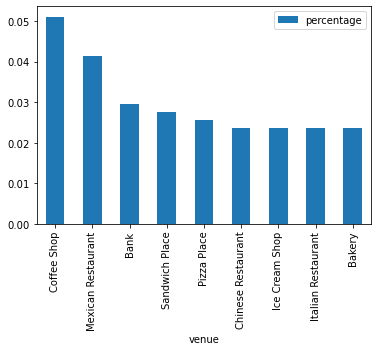

In [30]:
city_list=merged[merged['Cluster Labels']==1][['name','Cluster Labels']]
city_list_subgroup=city_list.merge(onehot,left_on='name',right_on='Neighborhood').drop(['name','Neighborhood'],axis=1).groupby('Cluster Labels', as_index=False).mean().transpose()
city_list_subgroup.columns=['percentage']
group2=city_list_subgroup.sort_values(by='percentage',ascending=False).head(10).reset_index()
group2.columns=['venue','percentage']
group2=group2[group2['venue']!='Cluster Labels']
group2.plot(x='venue',y='percentage',kind='bar')

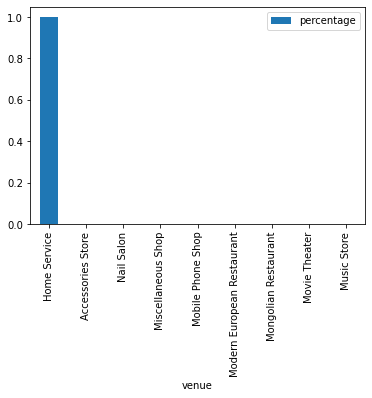

In [31]:
city_list=merged[merged['Cluster Labels']==2][['name','Cluster Labels']]
city_list_subgroup=city_list.merge(onehot,left_on='name',right_on='Neighborhood').drop(['name','Neighborhood'],axis=1).groupby('Cluster Labels', as_index=False).mean().transpose()
city_list_subgroup.columns=['percentage']
group3=city_list_subgroup.sort_values(by='percentage',ascending=False).head(10).reset_index()
group3.columns=['venue','percentage']
group3=group3[group3['venue']!='Cluster Labels']
group3.plot(x='venue',y='percentage',kind='bar')

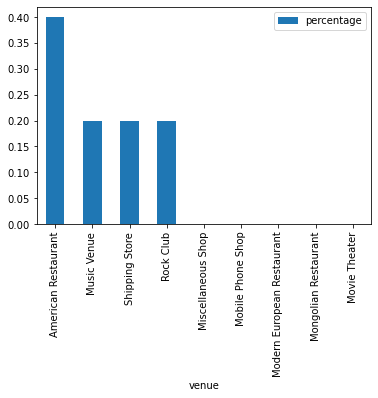

In [32]:
city_list=merged[merged['Cluster Labels']==3][['name','Cluster Labels']]
city_list_subgroup=city_list.merge(onehot,left_on='name',right_on='Neighborhood').drop(['name','Neighborhood'],axis=1).groupby('Cluster Labels', as_index=False).mean().transpose()
city_list_subgroup.columns=['percentage']
group4=city_list_subgroup.sort_values(by='percentage',ascending=False).head(10).reset_index()
group4.columns=['venue','percentage']
group4=group4[group4['venue']!='Cluster Labels']
group4.plot(x='venue',y='percentage',kind='bar')